# Práctica 5: Planificación con incertidumbre

## Inteligencia Artificial para la Robótica
### M.U en Lógica, Computación e Inteligencia Artificial
### Universidad de Sevilla

El paquete de _Python_ [pymdptoolbox](https://github.com/sawcordwell/pymdptoolbox) proporciona un marco de trabajo para procesos de decisión de Markov.

El paquete proporciona tres módulos:
* El módulo _mdp_ es el que implementa los procesos de decisión de Markov y los algoritmos de iteración de valores y de políticas, entre otros.
* El módulo _util_ proporciona algunas funciones para comprobar la correcta descripción del proceso de decisión de Markov, como por ejemplo que la función de transición de cada acción aplicada a cada estado es una distribución de probabilidad (las probabilidades de los nuevos estados están en el intervalo $[0, 1]$ y suman $1$).
* El modulo _example_ proporciona algunos ejemplos.

En esta práctica solo usaremos el primero de esos módulos.

In [2]:
import mdptoolbox.mdp as mdp

Los algoritmos para calcular una política óptima utilizan operaciones matriciales, por lo que también necesitaremos hacer uso del paquete [Numpy](https://numpy.org/).

In [1]:
import numpy as np

# Ejemplo del robot y las cinco localizaciones

Recordemos que en el tema hemos visto un ejemplo de proceso de decisión de Markov en el que tenemos un robot que puede encontrarse en una de entre cinco localizaciones y trata de moverse entre ellas, con el objetivo de llegar a una localización concreta.

Los estados del sistema están representados por un predicado `en`, que indica la localización en la que se encuentra el robot.

In [3]:
estados = ['en(l1)', 'en(l2)', 'en(l3)', 'en(l4)', 'en(l5)']

Las posibles acciones que puede realizar el robot son `esperar` o `ir` de una localización a otra (pero no para cualquier par de localizaciones hay un camino directo).

In [4]:
acciones = ['esperar',
            'ir(l1, l2)', 'ir(l1, l4)',
            'ir(l2, l1)', 'ir(l2, l3)',
            'ir(l3, l2)', 'ir(l3, l4)',
            'ir(l4, l1)', 'ir(l4, l3)', 'ir(l4, l5)',
            'ir(l5, l2)', 'ir(l5, l4)']

En realidad, las listas de estados y acciones anteriores no son necesarias, ya que el paquete trabaja con la enumeración de estados (`0` es el estado `en(l1)`, `1` es el estado `en(l2)`, ...) y de las acciones (`0` es la acción `esperar`, `1` es la acción `ir(l1, l2)`, ...). Pero nos servirán para transformar las respuestas de los algoritmos a un formato más amigable.

La acción `esperar` deja al robot en la misma localización en que se encuentre con probabilidad $1$ y tiene coste $0$. La función de transición del resto de acciones, sus costes y las recompensas de los estados se encuentran recogidas en el siguiente gráfico:

![](Recompensas_y_costes.png)

Las recompensas de los estados se representan mediante un array unidimensional.

In [5]:
recompensas_estados = np.array([0, 0, 0, 100, -100])
print(recompensas_estados)

[   0    0    0  100 -100]


La función de transición y el coste de aplicación para cada acción se representan, respectivamente, mediante un array bidimensional y un array unidimensional. Por ejemplo, para la acción `esperar` la función de transición vendrá dada por la matriz identidad $5 \times 5$ y el coste de aplicación por el vector nulo de longitud $5$.

In [6]:
transición_esperar = np.array([[1, 0, 0, 0, 0],
                                  [0, 1, 0, 0, 0],
                                  [0, 0, 1, 0, 0],
                                  [0, 0, 0, 1, 0],
                                  [0, 0, 0, 0, 1]])
print(transición_esperar)

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


In [7]:
coste_esperar = np.array([0, 0, 0, 0, 0])
print(coste_esperar)

[0 0 0 0 0]


Un detalle importante es que el paquete asume que todas las acciones son ejecutables en todos los estados. Representaremos que una acción no es ejecutable en un estado estableciendo que el estado no cambia y que la ejecución tiene un coste muy alto (de hecho, podremos establecer coste infinito). De esta forma, el algoritmo no seleccionará la acción para la política óptima. Por ejemplo, para la acción `ir(l1, l2)` se tiene la siguiente matriz de transición y vector de costes:

In [8]:
transición_ir_l1_l2 = np.array([[0, 1, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 1]])
print(transición_ir_l1_l2)

[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


In [9]:
coste_ir_l1_l2 = np.array([100, np.inf, np.inf, np.inf, np.inf])
print(coste_ir_l1_l2)

[100.  inf  inf  inf  inf]


Análogamente, para el resto de acciones se tienen las siguientes matrices de transición y vectores de coste:

In [10]:
transición_ir_l1_l4 = np.array([[.5, 0, 0, .5, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l1_l4 = np.array([1, np.inf, np.inf, np.inf, np.inf])

transición_ir_l2_l1 = np.array([[1, 0, 0, 0, 0],
                                   [1, 0, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l2_l1 = np.array([np.inf, 100, np.inf, np.inf, np.inf])

transición_ir_l2_l3 = np.array([[1, 0, 0, 0, 0],
                                   [0, 0, .8, 0, .2],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l2_l3 = np.array([np.inf, 1, np.inf, np.inf, np.inf])

transición_ir_l3_l2 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l3_l2 = np.array([np.inf, np.inf, 1, np.inf, np.inf])

transición_ir_l3_l4 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l3_l4 = np.array([np.inf, np.inf, 100, np.inf, np.inf])

transición_ir_l4_l1 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l4_l1 = np.array([np.inf, np.inf, np.inf, 1, np.inf])

transición_ir_l4_l3 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 0, 1]])
coste_ir_l4_l3 = np.array([np.inf, np.inf, np.inf, 100, np.inf])

transición_ir_l4_l5 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 0, 1],
                                   [0, 0, 0, 0, 1]])
coste_ir_l4_l5 = np.array([np.inf, np.inf, np.inf, 100, np.inf])

transición_ir_l5_l2 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 1, 0, 0, 0]])
coste_ir_l5_l2 = np.array([np.inf, np.inf, np.inf, np.inf, 1])

transición_ir_l5_l4 = np.array([[1, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0],
                                   [0, 0, 1, 0, 0],
                                   [0, 0, 0, 1, 0],
                                   [0, 0, 0, 1, 0]])
coste_ir_l5_l4 = np.array([np.inf, np.inf, np.inf, np.inf, 100])

Finalmente, para calcular una política óptima del proceso de decisión de Markov hay que pasarle a los algoritmos un array tridimensional de todas las matrices de transición y un array bidimensional de las recompensas de los estados menos los costes de las acciones.

In [11]:
transiciones_sistema = np.array([transición_esperar,
                                    transición_ir_l1_l2,
                                    transición_ir_l1_l4,
                                    transición_ir_l2_l1,
                                    transición_ir_l2_l3,
                                    transición_ir_l3_l2,
                                    transición_ir_l3_l4,
                                    transición_ir_l4_l1,
                                    transición_ir_l4_l3,
                                    transición_ir_l4_l5,
                                    transición_ir_l5_l2,
                                    transición_ir_l5_l4])

In [12]:
transiciones_sistema.shape

(12, 5, 5)

In [13]:
matriz_recompensas = recompensas_estados.reshape(5, 1)
matriz_recompensas

array([[   0],
       [   0],
       [   0],
       [ 100],
       [-100]])

In [14]:
# Transformamos el vector de recompensas en una matriz 5x1
matriz_recompensas = recompensas_estados.reshape(5, 1)
# Creamos una matriz donde cada columna es el vector de costes de una acción
matriz_costes = np.column_stack([coste_esperar,
                                    coste_ir_l1_l2,
                                    coste_ir_l1_l4,
                                    coste_ir_l2_l1,
                                    coste_ir_l2_l3,
                                    coste_ir_l3_l2,
                                    coste_ir_l3_l4,
                                    coste_ir_l4_l1,
                                    coste_ir_l4_l3,
                                    coste_ir_l4_l5,
                                    coste_ir_l5_l2,
                                    coste_ir_l5_l4])

recompensas_sistema = matriz_recompensas - matriz_costes
print(recompensas_sistema)
print(recompensas_estados)

[[   0. -100.   -1.  -inf  -inf  -inf  -inf  -inf  -inf  -inf  -inf  -inf]
 [   0.  -inf  -inf -100.   -1.  -inf  -inf  -inf  -inf  -inf  -inf  -inf]
 [   0.  -inf  -inf  -inf  -inf   -1. -100.  -inf  -inf  -inf  -inf  -inf]
 [ 100.  -inf  -inf  -inf  -inf  -inf  -inf   99.    0.    0.  -inf  -inf]
 [-100.  -inf  -inf  -inf  -inf  -inf  -inf  -inf  -inf  -inf -101. -200.]]
[   0    0    0  100 -100]


In [15]:
recompensas_sistema.shape

(5, 12)

Para obtener una política óptima mediante el algoritmo de iteración de valores hay que crear una instancia adecuada de la clase `ValueIteration`. Hay que tener en cuenta que el valor de $\epsilon$ que se proporciona es la diferencia máxima que se requiere entre el último $U_{n}$ calculado y $U^{*}$, para lo que se deriva a partir de él la diferencia máxima adecuada entre $U_{n}$ y $U_{n - 1}$. Por otra parte, $U_{0}$ asigna utilidad inicial $0$ a todos los estados.

In [16]:
ejemplo_robot_VI = mdp.ValueIteration(
    transitions=transiciones_sistema,
    reward=recompensas_sistema,
    discount=0.9,
    epsilon=0.1
)

Para ejecutar el algoritmo basta usar el método `run` de la clase anterior, pero antes establecemos el modo verboso, para que proporcione detalles de los cálculos.

In [17]:
ejemplo_robot_VI.setVerbose()
ejemplo_robot_VI.run()

  Iteration		V-variation
    1		  200.0
    2		  91.0
    3		  81.0
    4		  28.000000000000007
    5		  4.191750000000042
    6		  1.8862875000000372
    7		  0.8488293750000651
    8		  0.38197321875003354
    9		  0.17188794843758615
    10		  0.07734957679679155
    11		  0.034807309558630095
    12		  0.015663289301357963
    13		  0.0070484801857446655
Iterating stopped, epsilon-optimal policy found.


La política óptima se encuentra guardada en el atributo `policy`.

In [18]:
ejemplo_robot_VI.policy

(2, 4, 6, 0, 11)

Con la siguiente expresión podemos verla de manera más amigable.

In [19]:
for estado, i in zip(estados, ejemplo_robot_VI.policy):
    print(f'En el estado {estado} ejecuta la acción {acciones[i]}')

En el estado en(l1) ejecuta la acción ir(l1, l4)
En el estado en(l2) ejecuta la acción ir(l2, l3)
En el estado en(l3) ejecuta la acción ir(l3, l4)
En el estado en(l4) ejecuta la acción esperar
En el estado en(l5) ejecuta la acción ir(l5, l4)


De manera análoga, se puede obtener una política óptima mediante el algoritmo de iteración de políticas creando una instancia adecuada de la clase `PolicyIteration`.

In [20]:
ejemplo_robot_PI = mdp.PolicyIteration(
    transitions=transiciones_sistema,
    reward=recompensas_sistema,
    discount=0.9,
    policy0=np.array([0, 0, 0, 0, 0])  # La política inicial es esperar en cada estado
)

ejemplo_robot_PI.setVerbose()
ejemplo_robot_PI.run()

print()
for estado, i in zip(estados, ejemplo_robot_PI.policy):
    print(f'En el estado {estado} ejecuta la acción {acciones[i]}')

  Iteration		Number of different actions
    1		  3
    2		  1
    3		  0
Iterating stopped, unchanging policy found.

En el estado en(l1) ejecuta la acción ir(l1, l4)
En el estado en(l2) ejecuta la acción ir(l2, l3)
En el estado en(l3) ejecuta la acción ir(l3, l4)
En el estado en(l4) ejecuta la acción esperar
En el estado en(l5) ejecuta la acción ir(l5, l4)


# Ejemplo de navegación

En este ejemplo vamos a reproducir el ejemplo de MDP planteado en el capítulo 14 del libro *Probabilistic Robotics*

Tendremos una mapa definido por una matriz de ocupación y un goal, leeremos estos datos de un fichero en el que primeramente vendrán las coordenadas del goal y luego vendrá línea por línea la matriz de ocupación, en dónde 1 significa obstáculo y 0 significa libre.

In [21]:
# El siguiente código lee el goal y el mapa del fichero

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])


In [22]:
# usaremos el fichero map.txt adjunto con la práctica

mapa,destino = lee_mapa("map.txt")
print(mapa)
print(destino)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1

Para visualizar el mapa, utilizaremos matplotlib, como venimos haciendo en prácticas anteriores, la siguiente función realiza la visualización del mapa. El goal se señala como un punto rojo.

In [23]:
import matplotlib.pyplot as plt
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
   
    

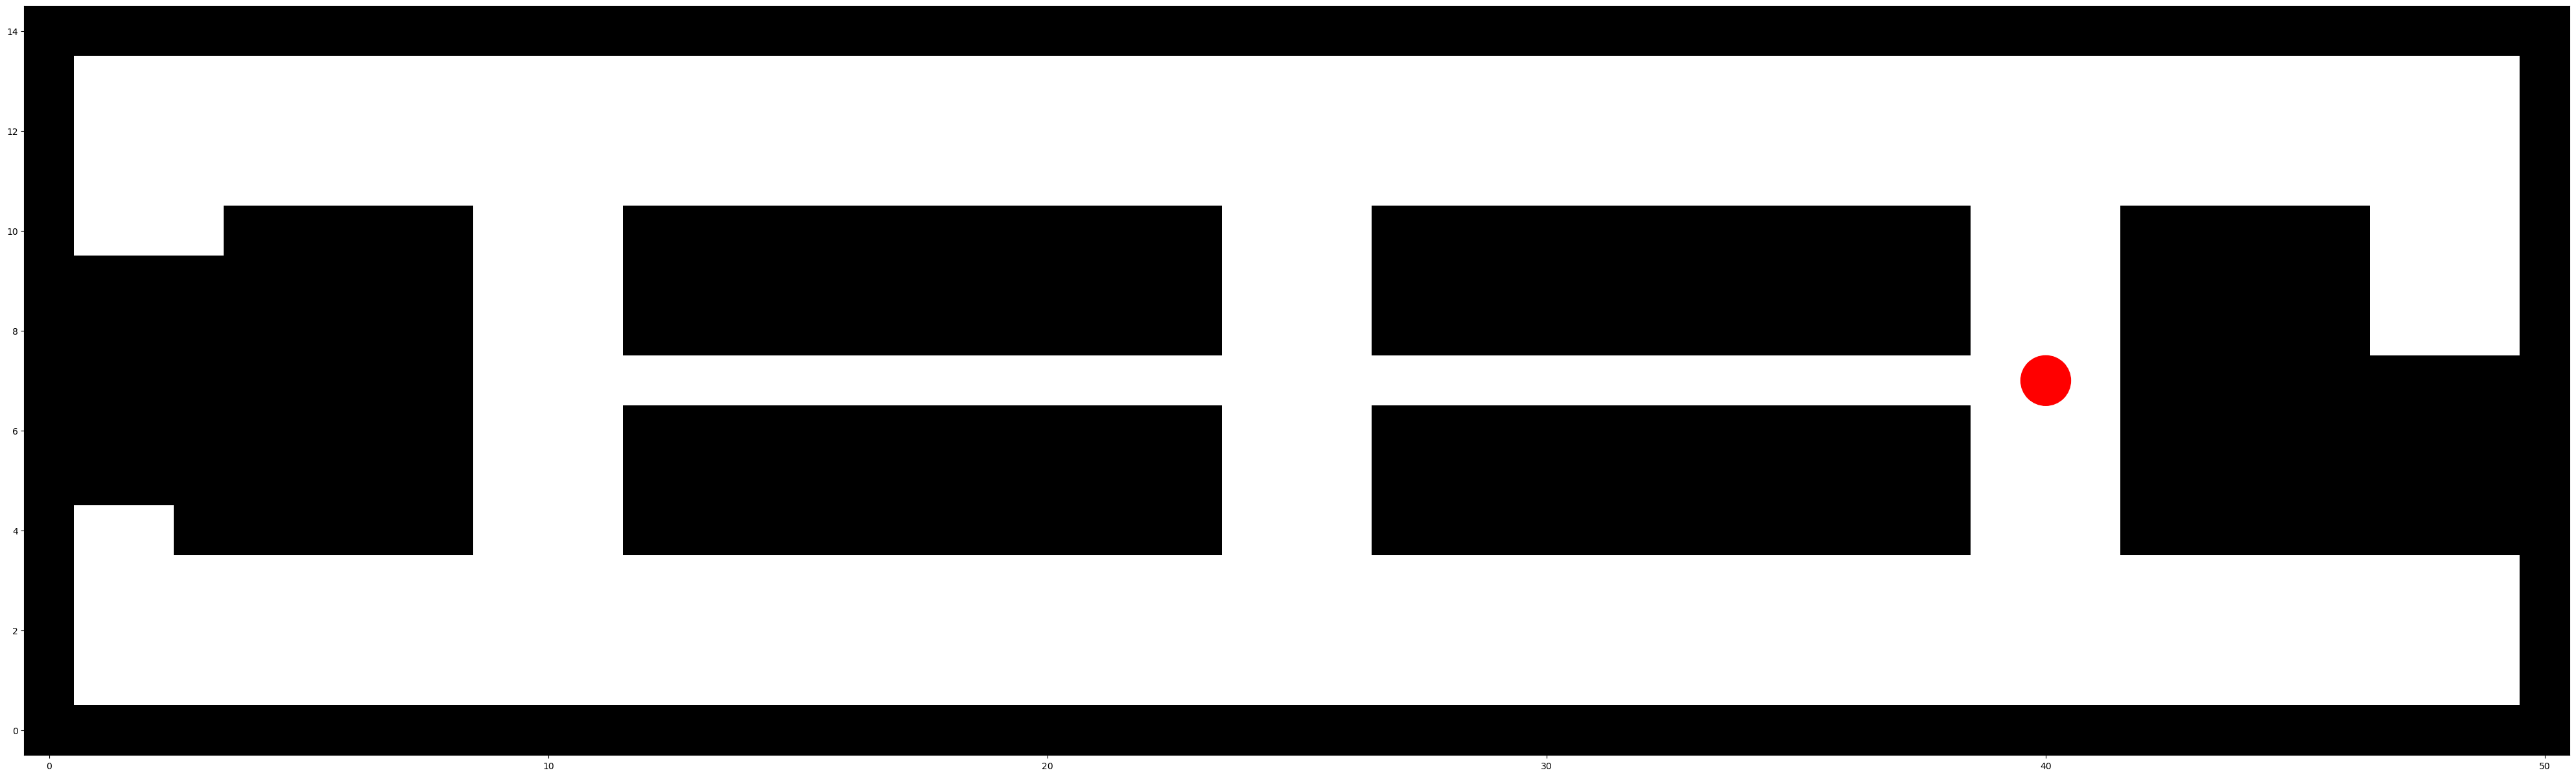

In [24]:
visualiza_mapa()


Los estados del problema serán las casillas del mapa (incluso las que tienen obstáculos), el siguiente código extrae los estados como una lista de tuplas (x,y)

In [25]:
nav_estados = []
for i in range(0,mapa.shape[1]):
    for j in range(0,mapa.shape[0]):
        nav_estados.append(tuple([i,j]))
nav_estados

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 0),
 (7, 1),
 (

Necesitaremos saber si hay colisión en una casilla (el mapa tiene 1 en la celda correspondiente), para ello se puede usar la siguiente función:

In [26]:
def hay_colision(estado):
    return mapa[estado[1],estado[0]]==1

In [27]:
hay_colision((4,3))

False

Las acciones de navegación serán "esperar" (es decir, quedarse en el sitio) o bien moverse hacia una de las 8 casillas adyacentes.

In [65]:
nav_acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']


El siguiente código aplica una acción a un estado dado y devuelve el estado resultante (x,y), si se parte de un estado e0 que representa un obstáculo, el movimiento es imposible y se devuelve el estado e0 

In [29]:
def aplica_accion(estado,accion):
    if hay_colision(estado):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x,y
        

In [30]:
aplica_accion((2,2),'NE')

(3, 3)

La recompensa en un estado es:

* -1000 si el estado es un obstáculo
* -distancia_euclidea_al_goal si el estado no es un obstáculo

De esta forma, penalizamos los obstáculos y en cualquier otro caso, habrá recompensa menos negativa cuanto más cerca se esté del objetivo

In [31]:
def obtiene_recompensa(estado):
    if hay_colision(estado):
        valor = -1000
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

In [32]:
print(obtiene_recompensa((8,2)))
print(obtiene_recompensa((7,2)))
print(obtiene_recompensa((4,3)))

-32.38826948140329
-33.37663853655727
-36.22154055254967


El siguiente código visualiza la recompensa de los estados libres de obstáculos con un gradiente de color desde blanco (menor recompensa) a azul (mayor recompensa)

In [33]:
def visualiza_recompensas():
    visualiza_mapa()
    recompensas = [obtiene_recompensa(e) for e in nav_estados]
    recompensas = [np.nan if elemento == -1000 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa(e)
        if r == -1000:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)


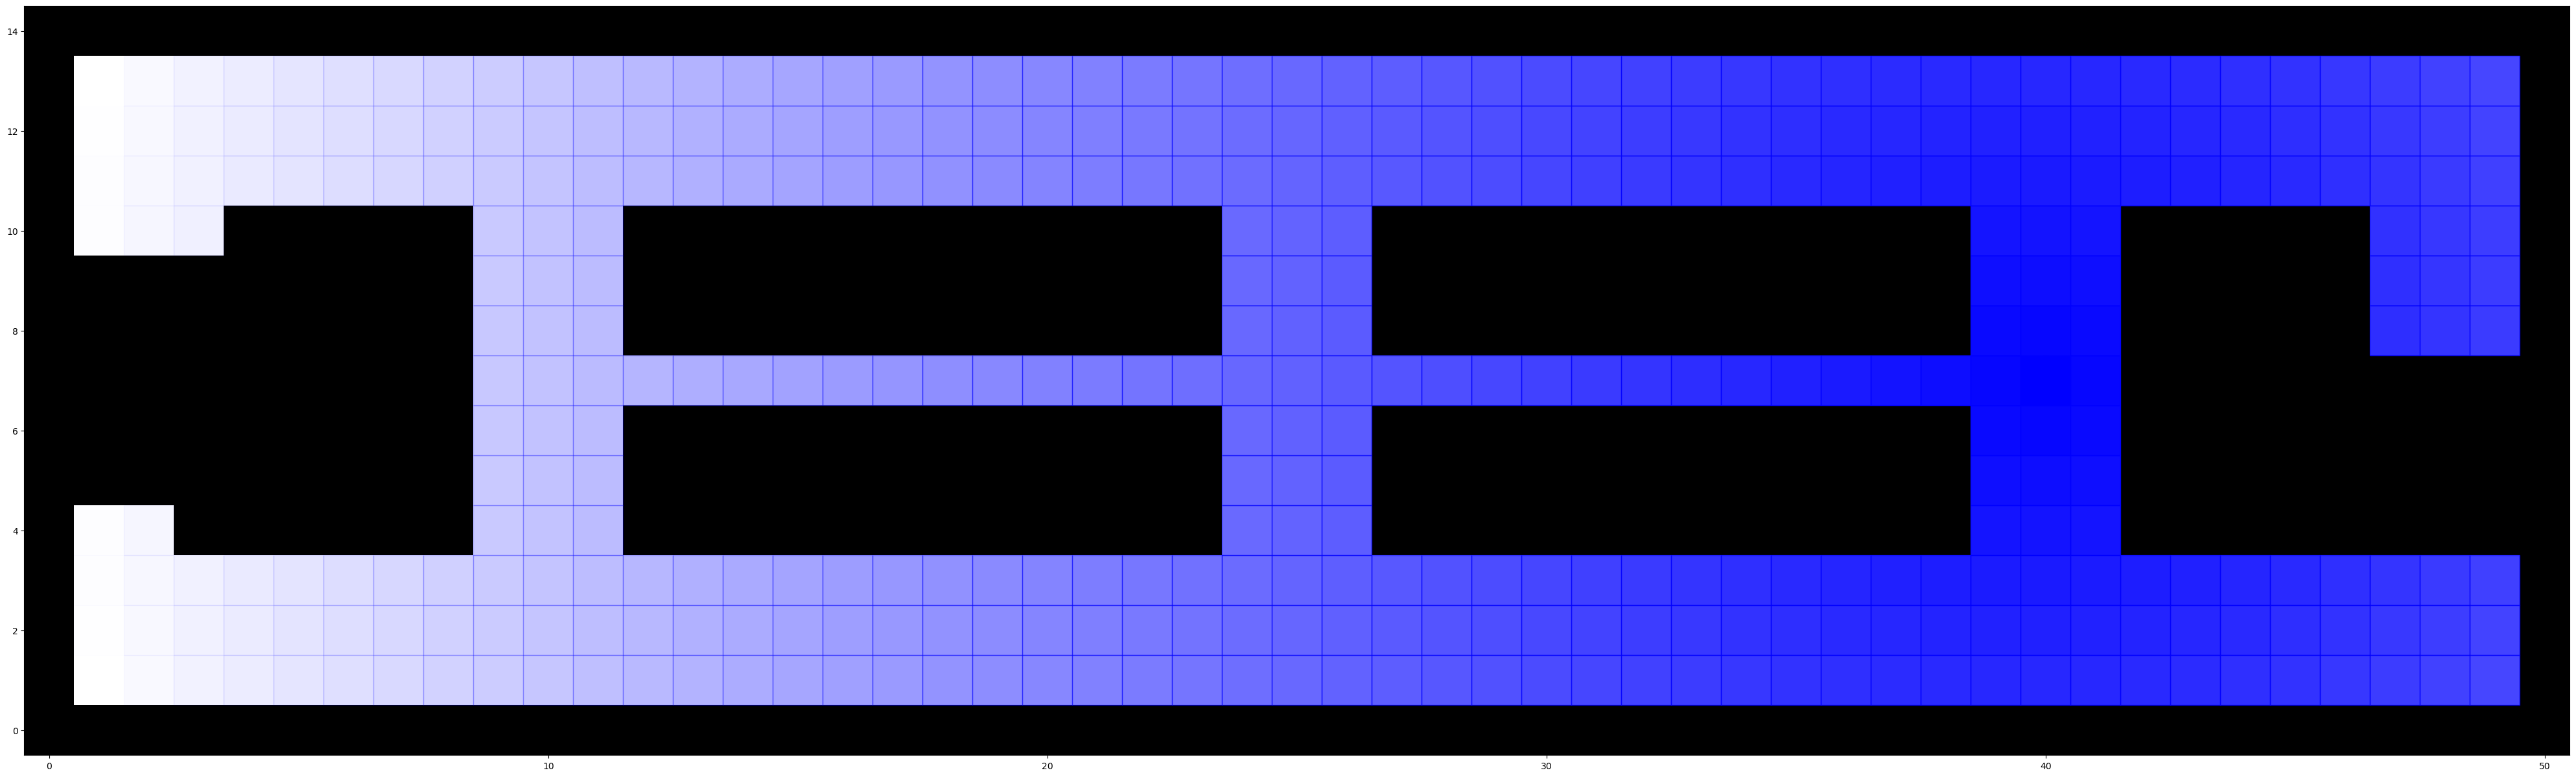

In [34]:
visualiza_recompensas()

Se puede diseñar una política ambiciosa o *greedy* que asigna a cada estado la acción que más acercaría el robot al objetivo (sin colisionar).

El siguiente código calcula dicha política y la devuelve como una lista de acciones, una por cada estado.

In [35]:
def crea_politica_greedy():
    p = []
    for e in nav_estados:
        valores = []
        for a in nav_acciones:
            e1 = aplica_accion(e,a)
            valores.append(obtiene_recompensa(e1))
        accion = nav_acciones[np.argmax(valores)]
        p.append(accion)
    return p
            
            

In [36]:
politica_greedy = crea_politica_greedy()
for p in zip (nav_estados,politica_greedy):
    print(p)

((0, 0), 'esperar')
((0, 1), 'esperar')
((0, 2), 'esperar')
((0, 3), 'esperar')
((0, 4), 'esperar')
((0, 5), 'esperar')
((0, 6), 'esperar')
((0, 7), 'esperar')
((0, 8), 'esperar')
((0, 9), 'esperar')
((0, 10), 'esperar')
((0, 11), 'esperar')
((0, 12), 'esperar')
((0, 13), 'esperar')
((0, 14), 'esperar')
((1, 0), 'esperar')
((1, 1), 'NE')
((1, 2), 'NE')
((1, 3), 'NE')
((1, 4), 'E')
((1, 5), 'esperar')
((1, 6), 'esperar')
((1, 7), 'esperar')
((1, 8), 'esperar')
((1, 9), 'esperar')
((1, 10), 'E')
((1, 11), 'SE')
((1, 12), 'SE')
((1, 13), 'SE')
((1, 14), 'esperar')
((2, 0), 'esperar')
((2, 1), 'NE')
((2, 2), 'NE')
((2, 3), 'E')
((2, 4), 'SE')
((2, 5), 'esperar')
((2, 6), 'esperar')
((2, 7), 'esperar')
((2, 8), 'esperar')
((2, 9), 'esperar')
((2, 10), 'E')
((2, 11), 'SE')
((2, 12), 'SE')
((2, 13), 'SE')
((2, 14), 'esperar')
((3, 0), 'esperar')
((3, 1), 'NE')
((3, 2), 'NE')
((3, 3), 'E')
((3, 4), 'esperar')
((3, 5), 'esperar')
((3, 6), 'esperar')
((3, 7), 'esperar')
((3, 8), 'esperar')
((3, 

La siguiente función realiza la visualización de una política

In [37]:
def visualiza_politica(politica):
    visualiza_mapa()
    for p in zip(nav_estados,politica):
        accion = p[1]
        if accion=='esperar':
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

    

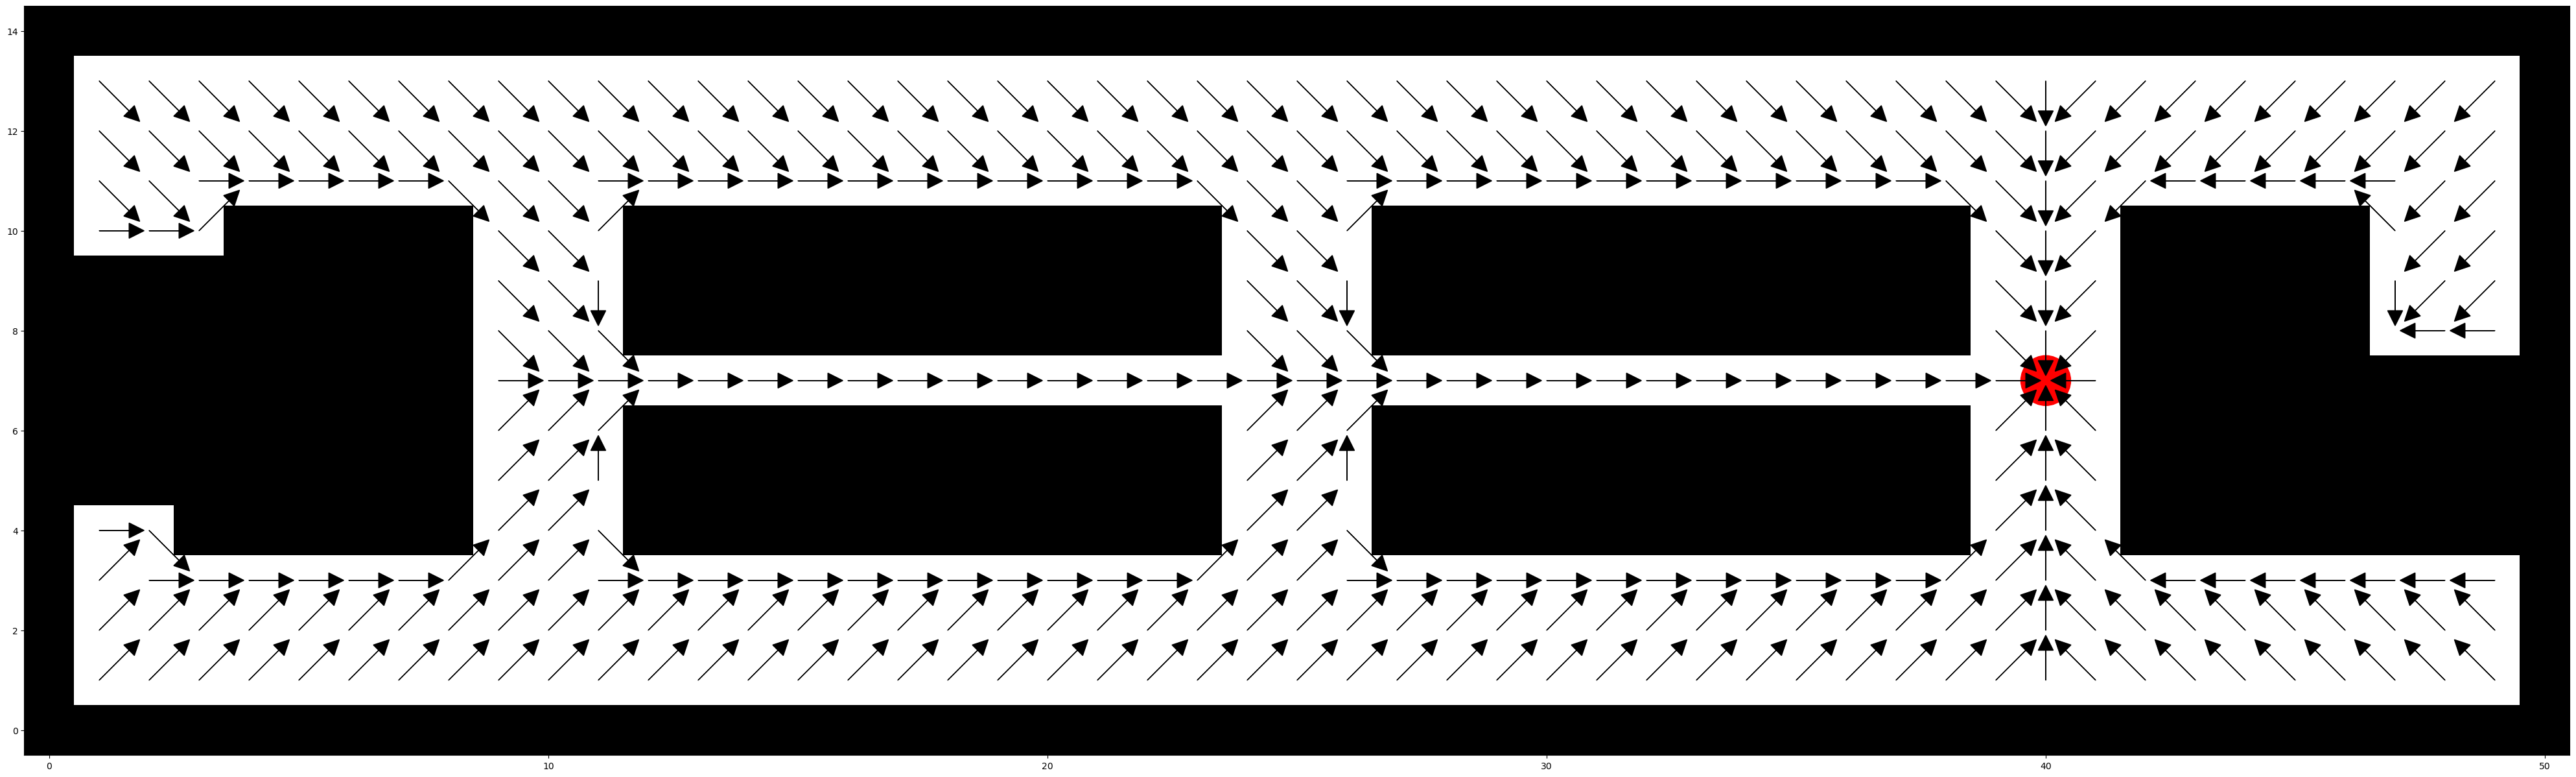

In [38]:
visualiza_politica(politica_greedy)

El siguiente código genera la matriz de recompensas SxA, en dónde:

* R(s,a) = -100 si *s* es un estado distinto del goal y *a* es *esperar*
* R(s,a) = R(s) en cualquier otro caso

In [39]:
def crea_recompensas_sistema():
    matriz = []
    for e in nav_estados:
        r = obtiene_recompensa(e)
        fila = [r]*len(nav_acciones)
        if e != destino:
            fila[0]=-100
        matriz.append(fila)
    return np.array(matriz)

In [40]:
nav_recompensas_sistema = crea_recompensas_sistema()

In [41]:
print(nav_estados[160])
print(nav_acciones)
print(nav_recompensas_sistema[160,0])
print(nav_recompensas_sistema[160,1])
print(nav_recompensas_sistema[160,2])
print(nav_recompensas_sistema[160,3])


(10, 10)
['esperar', 'N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']
-100.0
-30.14962686336267
-30.14962686336267
-30.14962686336267


In [42]:
nav_recompensas_sistema.shape

(765, 9)

El siguiente código obtiene el índice único de un estado a partir de sus coordenadas. El índice es la posición del estado en la lista de estados.

In [43]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[0]+estado[1])

In [44]:
print(obtiene_indice_estado((10,7)))

157


Vamos a suponer que el movimiento del robot no es perfecto y puede desviarse a izquierda o derecha de su trayectoria, es decir:

* Si va en dirección N, podría terminar en dirección NE o NO
* Si va en dirección S, podría terminar en dirección SE o SO
* Si va en dirección E, podría terminar en dirección NE o SE
* Si va en dirección O, podría terminar en direcicón NO o SO
* Si va en dirección NE, podría terminar en dirección N o E
* Si va en dirección NO, podría terminar en dirección N u O
* Si va en dirección SE, podría terminar en dirección S o E
* Si va en dirección SO, podría terminar en dirección S u O

El siguiente código devuelve la lista de posibles acciones de error dada una acción. Téngase en cuenta, que la acción esperar no tiene error.

In [45]:
def obtiene_posibles_errores(accion):
    if accion=='N':
        errores = ['NE','NO']
    elif accion=='S':
        errores = ['SE','SO']
    elif accion=='E':
        errores = ['NE','SE']
    elif accion=='O':
        errores = ['NO', 'SO']
    elif accion=='NE':
        errores = ['N','E']
    elif accion=='NO':
        errores = ['N','O']
    elif accion=='SE':
        errores = ['S','E']
    elif accion == 'SO':
        errores = ['S','O']
    else:
        errores = []
    return errores

In [46]:
obtiene_posibles_errores('SE')

['S', 'E']

In [47]:
obtiene_posibles_errores('esperar')

[]

El siguiente código crea la matriz de transición SxS para una acción determinada y una probabilidad de error *prob_error*

* Con probabilidad *1 - prob_error*, el estado resultante será el correspondiente a aplicar la acción correctamente.
* Con probabilidad *prob_error/N*, el estado resultante será el correspondiente a aplicar una de las posibles acciones de error devueltas por la función anterior, en donde N es el número de acciones de error 

In [48]:
def crea_transiciones_movimiento(accion, prob_error):
    matriz = []
    for e0 in nav_estados:
        fila = [0]*len(nav_estados)
        if hay_colision(e0):
            fila[obtiene_indice_estado(e0)]=1
        else:
            goal = aplica_accion(e0,accion)
            errores = obtiene_posibles_errores(accion)
            if len(errores)==0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0,error)
                    fila[obtiene_indice_estado(goal_error)] = prob_error/len(errores)
        matriz.append(fila)
    return np.array(matriz)
       
            

In [49]:
test = crea_transiciones_movimiento('N',0.2)
print(test[0,0])
print(test[obtiene_indice_estado((10,7)),obtiene_indice_estado((10,8))])
print(test[obtiene_indice_estado((10,7)),obtiene_indice_estado((9,8))])
print(test[obtiene_indice_estado((10,7)),obtiene_indice_estado((11,8))])

1.0
0.8
0.1
0.1


El siguiente código genera todas las transiciones del sistema como un array AxSxS

In [50]:
def crea_transiciones_sistema(prob_error):
    return np.array([crea_transiciones_movimiento('esperar',prob_error), 
                     crea_transiciones_movimiento('N',prob_error),
                     crea_transiciones_movimiento('NE',prob_error),
                     crea_transiciones_movimiento('E',prob_error),
                     crea_transiciones_movimiento('SE',prob_error),
                     crea_transiciones_movimiento('S',prob_error),
                     crea_transiciones_movimiento('SO',prob_error),
                     crea_transiciones_movimiento('O',prob_error),
                     crea_transiciones_movimiento('NO',prob_error)])

In [51]:
nav_transiciones_sistema = crea_transiciones_sistema(0.2)

In [52]:
nav_transiciones_sistema.shape

(9, 765, 765)

El siguiente diccionario devuelve el índice de una acción dado el nombre de la acción, será necesario porque los métodos de mdptoolbox utilizan índices para estados y acciones

In [53]:
indices_nav_acciones = {'esperar': 0, 'N': 1, 'NE': 2, 'E': 3, 'SE': 4, 'S': 5, 'SO': 6, 'O': 7, 'NO': 8}

El siguiente código traduce la política greedy a un array de índices de acciones, será la política por defecto que se utilizará en el agoritmo de Policy Iteration

In [56]:
politica_por_defecto = np.array([indices_nav_acciones[x] for x in politica_greedy])
politica_por_defecto

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0,
       0, 0, 0, 3, 4, 4, 4, 0, 0, 2, 2, 3, 4, 0, 0, 0, 0, 0, 3, 4, 4, 4,
       0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 2, 3, 4, 4, 0, 0, 2, 2, 3, 0, 0,
       0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 3, 4,
       4, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 2, 2, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4,
       4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 0, 0, 2, 2, 2,
       2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 0, 0, 2, 2, 3, 4, 1, 2, 3, 4, 5, 2,
       3, 4, 4, 0, 0, 2, 2, 3, 0, 0, 0, 3, 0, 0, 0, 3, 4, 4, 0, 0, 2, 2,
       3, 0, 0, 0, 3, 0, 0, 0, 3, 4, 4, 0, 0, 2, 2, 3, 0, 0, 0, 3, 0, 0,
       0, 3, 4, 4, 0, 0, 2, 2, 3, 0, 0, 0, 3, 0, 0, 0, 3, 4, 4, 0, 0, 2,
       2, 3, 0, 0, 0, 3, 0, 0, 0, 3, 4, 4, 0, 0, 2, 2, 3, 0, 0, 0, 3, 0,
       0, 0, 3, 4, 4, 0, 0, 2, 2, 3, 0, 0, 0, 3, 0, 0, 0, 3, 4, 4, 0, 0,
       2, 2, 3, 0, 0, 0, 3, 0, 0, 0, 3, 4, 4, 0, 0,

Ya estamos en condiones de plantear el problema como un MDP en mdptoolbox, utilizaremos el algoritmo Policy Iteration

In [57]:
import mdptoolbox.mdp as mdp
ejemplo_nav_robot = mdp.PolicyIteration(
    transitions=nav_transiciones_sistema,
    reward=nav_recompensas_sistema,
    discount=0.9,
    policy0=politica_por_defecto
)

Resolvemos el MDP

In [58]:
ejemplo_nav_robot.setVerbose()
ejemplo_nav_robot.run()


  Iteration		Number of different actions
    1		  247
    2		  156
    3		  58
    4		  7
    5		  4
    6		  1
    7		  0
Iterating stopped, unchanging policy found.


A continuación se muestra la acción para cada estado

In [59]:
for estado, i in zip(nav_estados, ejemplo_nav_robot.policy):
    print(f'En el estado {estado} ejecuta la acción {nav_acciones[i]}')

En el estado (0, 0) ejecuta la acción esperar
En el estado (0, 1) ejecuta la acción esperar
En el estado (0, 2) ejecuta la acción esperar
En el estado (0, 3) ejecuta la acción esperar
En el estado (0, 4) ejecuta la acción esperar
En el estado (0, 5) ejecuta la acción esperar
En el estado (0, 6) ejecuta la acción esperar
En el estado (0, 7) ejecuta la acción esperar
En el estado (0, 8) ejecuta la acción esperar
En el estado (0, 9) ejecuta la acción esperar
En el estado (0, 10) ejecuta la acción esperar
En el estado (0, 11) ejecuta la acción esperar
En el estado (0, 12) ejecuta la acción esperar
En el estado (0, 13) ejecuta la acción esperar
En el estado (0, 14) ejecuta la acción esperar
En el estado (1, 0) ejecuta la acción esperar
En el estado (1, 1) ejecuta la acción NE
En el estado (1, 2) ejecuta la acción E
En el estado (1, 3) ejecuta la acción SE
En el estado (1, 4) ejecuta la acción SE
En el estado (1, 5) ejecuta la acción esperar
En el estado (1, 6) ejecuta la acción esperar
En e

Traducimos la política devuelta por el algoritmo a una lista de nombres de acciones, que es lo que requiere nuestro método de visualización

In [60]:
nav_politica = [nav_acciones[i] for i in ejemplo_nav_robot.policy]

Visualización de la política obtenida

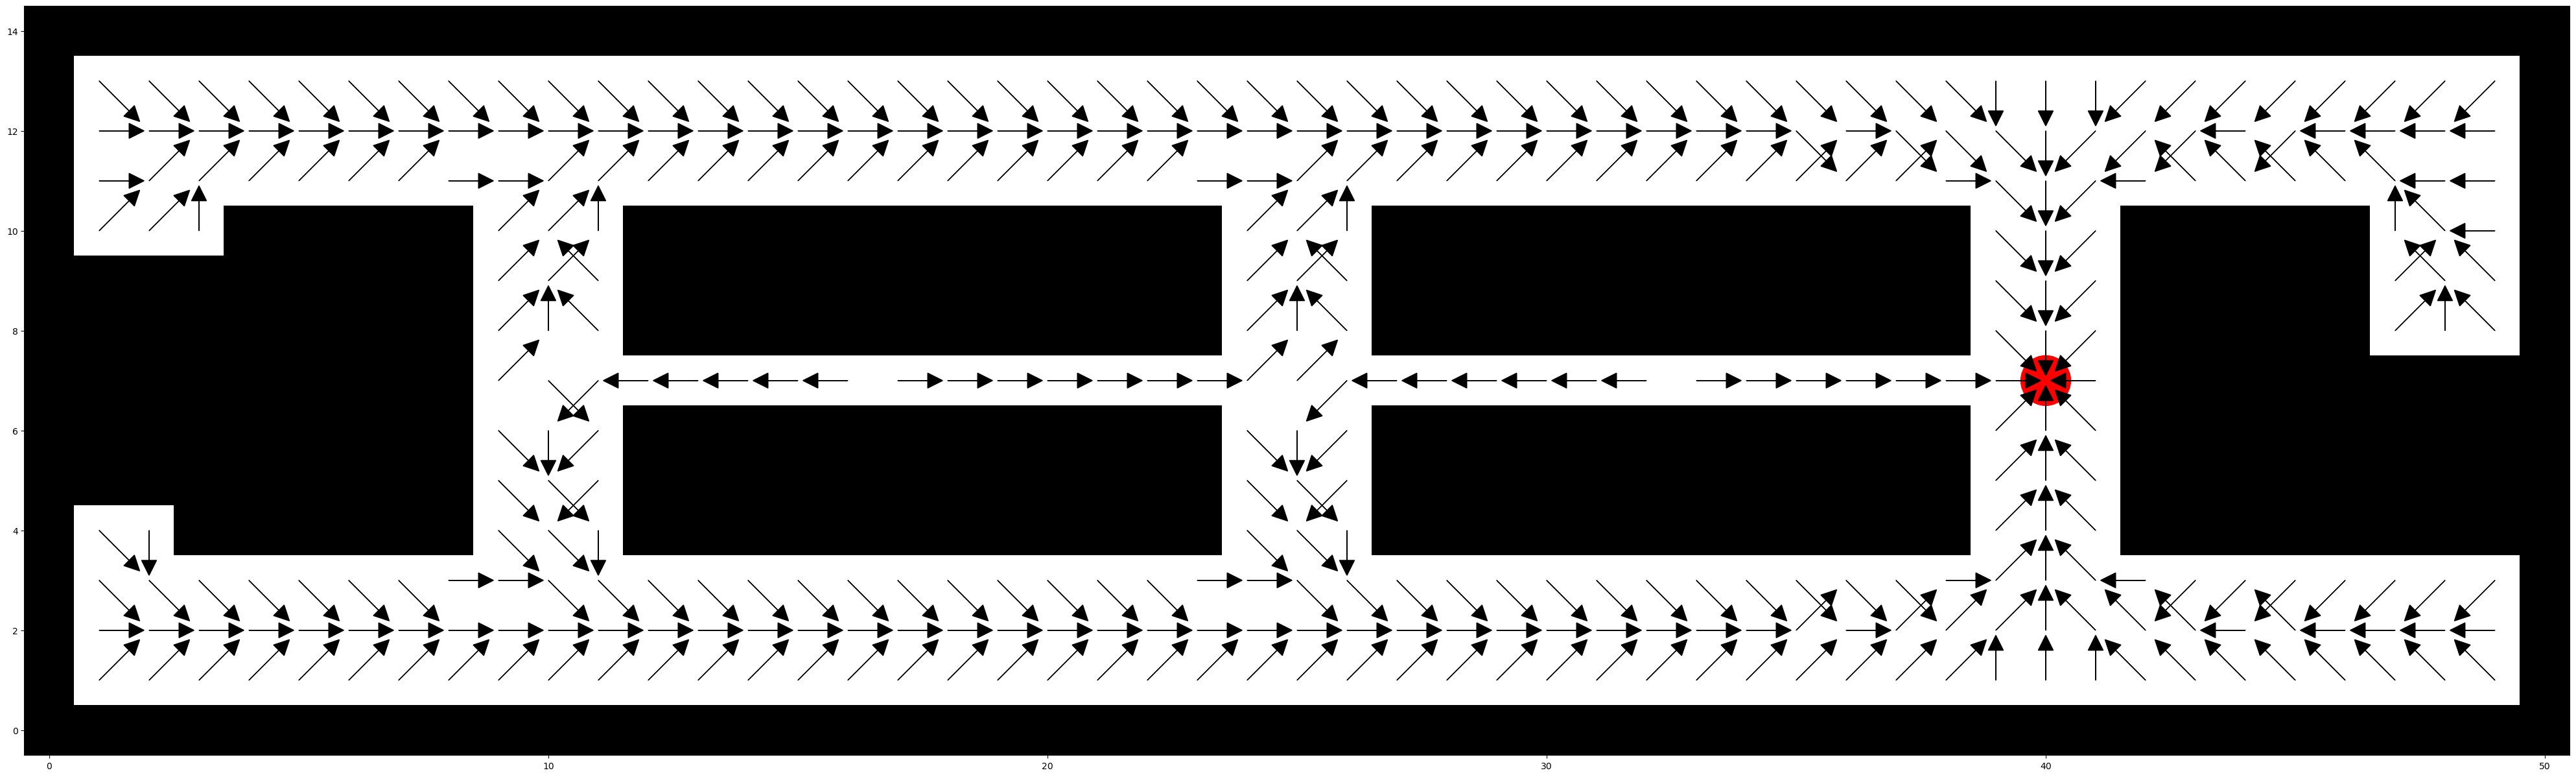

In [61]:
visualiza_politica(nav_politica)

### Cuestión 1: 

¿Qué se observa en la política devuelta por el algoritmo? ¿en qué mejora a la política greedy? ¿Se observa alguna anomalía? ¿a qué puede ser debido? 

<span style="color:green">**Escribe tu respuesta aquí**</span>

### Ejercicio 1:

Los métodos anteriores se han implementado poco a poco por cuestiones pedagógicas, ahora vamos a integrarlo todo en una única función llamada **navigate_with_uncertainty** que recibe:

* El nombre del fichero del escenario **scenario**
* La penalización por obstáculo **obstacle_penalty** (por defecto es -1000, valor que se ha usado en el ejemplo)
* La penalización por esperar **waiting_penalty** en un estado distinto al objetivo por defecto es -100, valor que se ha usado en el ejemplo)
* El factor de descuento **discount_factor** (por defecto es 0.9, valor que se ha usado en el ejemplo)

La función debe leer el escenario del fichero y generar la política greedy y la política óptima de acuerdo al algoritmo de Policy Iteration, debe mostrar por pantalla las dos visualizaciones en dos diagramas diferentes. No será necesario que devuelva nada.

Puedes usar las funciones auxiliares que estimes oportunas.



In [63]:
#Visualizamos el mapa
def visualiza_mapa(mapa):
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))

#generamos todos los estados posibles del mapa.
def genera_estados(mapa):
    nav_estados = []
    for i in range(0,mapa.shape[1]):
        for j in range(0,mapa.shape[0]):
            nav_estados.append(tuple([i,j]))
    return nav_estados



#Comprobamos si hay colisión en el estado según el mapa
def hay_colision(estado,mapa):
    return mapa[estado[1],estado[0]]==1

def aplica_accion(estado,accion):
    if hay_colision(estado,mapa):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x,y
        

#Generamos la penalizaciones por lejania del goal y por el obstaculo
def obtiene_recompensa(estado,obstacle_penalty,mapa):
    if hay_colision(estado,mapa):
        valor = obstacle_penalty
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

#Generamos las penalizaciones por esperar
def crea_recompensas_sistema(obstacle_penalty,mapa,waiting_penalty):
    matriz = []
    nav_estados =genera_estados(mapa)
    for e in nav_estados:
        r = obtiene_recompensa(e,obstacle_penalty,mapa)
        fila = [r]*len(nav_acciones)
        if e != destino:
            fila[0]=waiting_penalty
        matriz.append(fila)
    return np.array(matriz)


def obtiene_indice_estado(estado,mapa):
    return int(estado[0]*mapa.shape[0]+estado[1])

def crea_politica_greedy(mapa,obstacle_penalty):
    p = []
    nav_estados =genera_estados(mapa)
    for e in nav_estados:
        valores = []
        for a in nav_acciones:
            e1 = aplica_accion(e,a)
            valores.append(obtiene_recompensa(e1,obstacle_penalty,mapa))
        accion = nav_acciones[np.argmax(valores)]
        p.append(accion)
    return p

def visualiza_politica(politica,mapa):
    visualiza_mapa(mapa)
    nav_estados = genera_estados(mapa)
    for p in zip(nav_estados,politica):
        accion = p[1]
        if accion=='esperar':
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')
        
def crea_transiciones_movimiento(accion, prob_error,mapa):
    matriz = []
    nav_estados = genera_estados(mapa)
    for e0 in nav_estados:
        fila = [0]*len(nav_estados)
        if hay_colision(e0,mapa):
            fila[obtiene_indice_estado(e0,mapa)]=1
        else:
            goal = aplica_accion(e0,accion)
            errores = obtiene_posibles_errores(accion)
            if len(errores)==0:
                fila[obtiene_indice_estado(goal,mapa)] = 1
            else:
                fila[obtiene_indice_estado(goal,mapa)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0,error)
                    fila[obtiene_indice_estado(goal_error,mapa)] = prob_error/len(errores)
        matriz.append(fila)
    return np.array(matriz)

def crea_transiciones_sistema(prob_error,mapa):
    return np.array([crea_transiciones_movimiento('esperar',prob_error,mapa), 
                     crea_transiciones_movimiento('N',prob_error,mapa),
                     crea_transiciones_movimiento('NE',prob_error,mapa),
                     crea_transiciones_movimiento('E',prob_error,mapa),
                     crea_transiciones_movimiento('SE',prob_error,mapa),
                     crea_transiciones_movimiento('S',prob_error,mapa),
                     crea_transiciones_movimiento('SO',prob_error,mapa),
                     crea_transiciones_movimiento('O',prob_error,mapa),
                     crea_transiciones_movimiento('NO',prob_error,mapa)])

def navigate_with_uncertainty(scenario,obstacle_penalty=-1000,waiting_penalty=-100,discount_factor=0.9):
    #Politica voraz
    mapa,destino = lee_mapa(scenario)
    politicaG = crea_politica_greedy(mapa,obstacle_penalty)
    visualiza_politica(politicaG,mapa)
    #Politica optima
    nav_recompensas_sistema = crea_recompensas_sistema(obstacle_penalty,mapa,waiting_penalty)
    nav_transiciones_sistema = crea_transiciones_sistema(0.2,mapa)
    politica_por_defecto = np.array([indices_nav_acciones[x] for x in politica_greedy])
    politicaO = mdp.PolicyIteration(transitions=nav_transiciones_sistema,reward=nav_recompensas_sistema,
    discount=0.9,
    policy0=politica_por_defecto
)
    nav_politica = [nav_acciones[i] for i in politicaO.policy]
    visualiza_politica(nav_politica,mapa)
   
    
    
    
    


In [4]:
def obtiene_posibles_errores(accion):
    if accion=='N':
        errores = ['NE','NO']
    elif accion=='S':
        errores = ['SE','SO']
    elif accion=='E':
        errores = ['NE','SE']
    elif accion=='O':
        errores = ['NO', 'SO']
    elif accion=='NE':
        errores = ['N','E']
    elif accion=='NO':
        errores = ['N','O']
    elif accion=='SE':
        errores = ['S','E']
    elif accion == 'SO':
        errores = ['S','O']
    else:
        errores = []
    return errores

def crea_transiciones_sistema(prob_error, nav_estados, mapa):
    def crea_transiciones_movimiento(accion, prob_error):
        matriz = []
        for e0 in nav_estados:
            fila = [0]*len(nav_estados)
            if hay_colision(e0, mapa):
                fila[obtiene_indice_estado(e0, mapa)]=1
            else:
                goal = aplica_accion(e0,accion,mapa)
                errores = obtiene_posibles_errores(accion)
                if len(errores)==0:
                    fila[obtiene_indice_estado(goal, mapa)] = 1
                else:
                    fila[obtiene_indice_estado(goal, mapa)] = 1 - prob_error
                    for error in errores:
                        goal_error = aplica_accion(e0,error,mapa)
                        fila[obtiene_indice_estado(goal_error, mapa)] = prob_error/len(errores)
            matriz.append(fila)
        return np.array(matriz)
        
    return np.array([crea_transiciones_movimiento('esperar',prob_error), 
                     crea_transiciones_movimiento('N',prob_error),
                     crea_transiciones_movimiento('NE',prob_error),
                     crea_transiciones_movimiento('E',prob_error),
                     crea_transiciones_movimiento('SE',prob_error),
                     crea_transiciones_movimiento('S',prob_error),
                     crea_transiciones_movimiento('SO',prob_error),
                     crea_transiciones_movimiento('O',prob_error),
                     crea_transiciones_movimiento('NO',prob_error)])

def crea_recompensas_sistema(nav_estados, nav_acciones, obstacle_penalty, destino, mapa, waiting_penalty=-100):
    matriz = []
    for e in nav_estados:
        r = obtiene_recompensa(e, obstacle_penalty, destino, mapa)
        fila = [r]*len(nav_acciones)
        if e != destino:
            fila[0]=waiting_penalty
        matriz.append(fila)
    return np.array(matriz)

def aplica_accion(estado,accion,mapa):
    if hay_colision(estado, mapa):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x,y
        

def crea_nav_estados(mapa):
    nav_estados = []
    for i in range(0,mapa.shape[1]):
        for j in range(0,mapa.shape[0]):
            nav_estados.append(tuple([i,j]))
    return nav_estados


def crea_politica_greedy(nav_acciones, nav_estados, obstacle_penalty, destiny, mapa):
    p = []
    for e in nav_estados:
        valores = []
        for a in nav_acciones:
            e1 = aplica_accion(e,a,mapa)
            valores.append(obtiene_recompensa(e1, obstacle_penalty, destiny, mapa))
        accion = nav_acciones[np.argmax(valores)]
        p.append(accion)
    return p

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])

def obtiene_recompensa(estado, obstacle_penalty, destino, mapa):
    if hay_colision(estado, mapa):
        valor = obstacle_penalty
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

def hay_colision(estado, mapa):
    return mapa[estado[1],estado[0]]==1
def obtiene_indice_estado(estado, mapa):
    return int(estado[0]*mapa.shape[0]+estado[1])

import matplotlib.pyplot as plt
def visualiza_mapa(mapa, destino):
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
   
    

def visualiza_recompensas(mapa, destino, obstacle_penalty, nav_estados):
    visualiza_mapa(mapa, destino)
    recompensas = [obtiene_recompensa(e, obstacle_penalty, destino, mapa) for e in nav_estados]
    recompensas = [np.nan if elemento == -1000 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa(e, obstacle_penalty, destino, mapa)
        if r == -1000:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)


def visualiza_politica(politica, mapa, destino, nav_estados):
    visualiza_mapa(mapa, destino)
    for p in zip(nav_estados,politica):
        accion = p[1]
        if accion=='esperar':
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion,mapa)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

    

def navigate_with_uncertainty(scenario, obstacle_penalty=-1000, waiting_penalty=-100, discount_factor=0.9, prob_error = 0.2):
    mapa, destino = lee_mapa(scenario)
    nav_estados = crea_nav_estados(mapa)
    nav_acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']
    indices_nav_acciones = {'esperar': 0, 'N': 1, 'NE': 2, 'E': 3, 'SE': 4, 'S': 5, 'SO': 6, 'O': 7, 'NO': 8}
    politica_greedy = crea_politica_greedy(nav_acciones, nav_estados, obstacle_penalty, destino, mapa)
    politica_por_defecto = np.array([indices_nav_acciones[x] for x in politica_greedy])
    transitions=crea_transiciones_sistema(prob_error, nav_estados, mapa)
    reward=crea_recompensas_sistema(nav_estados, nav_acciones, obstacle_penalty, destino, mapa,  waiting_penalty)
    visualiza_politica(politica_greedy, mapa, destino, nav_estados)    

    # Run the MDP
    ejemplo_nav_robot = mdp.PolicyIteration(
            transitions=transitions,
            reward=reward,
            discount=discount_factor,
            policy0=politica_por_defecto
        )
    # Solve the MDP
    ejemplo_nav_robot.setVerbose()
    ejemplo_nav_robot.run()
    # Change the politic to something we can visualize
    nav_politica = [nav_acciones[i] for i in ejemplo_nav_robot.policy]
    # Plot the politic
    visualiza_politica(nav_politica, mapa, destino, nav_estados)
    pass

Prueba tu método con las siguientes llamadas:


  Iteration		Number of different actions
    1		  247
    2		  156
    3		  58
    4		  7
    5		  4
    6		  1
    7		  0
Iterating stopped, unchanging policy found.


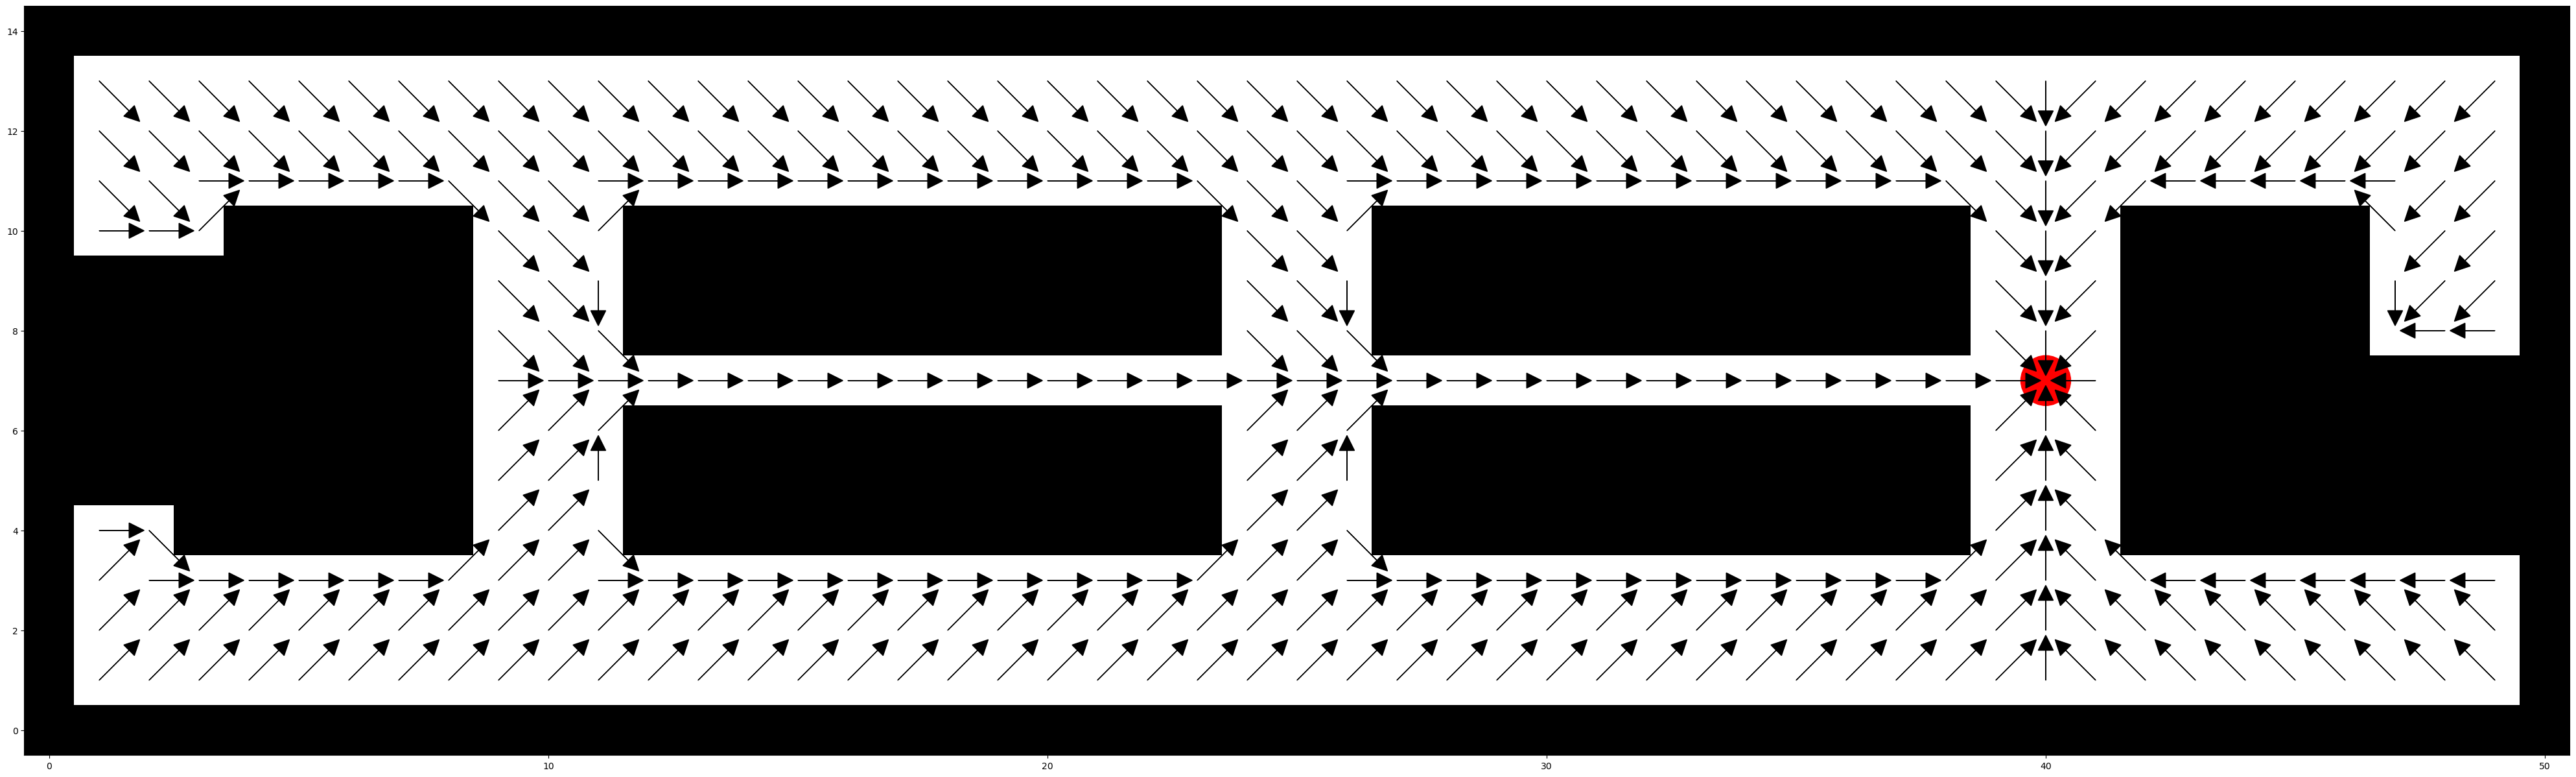

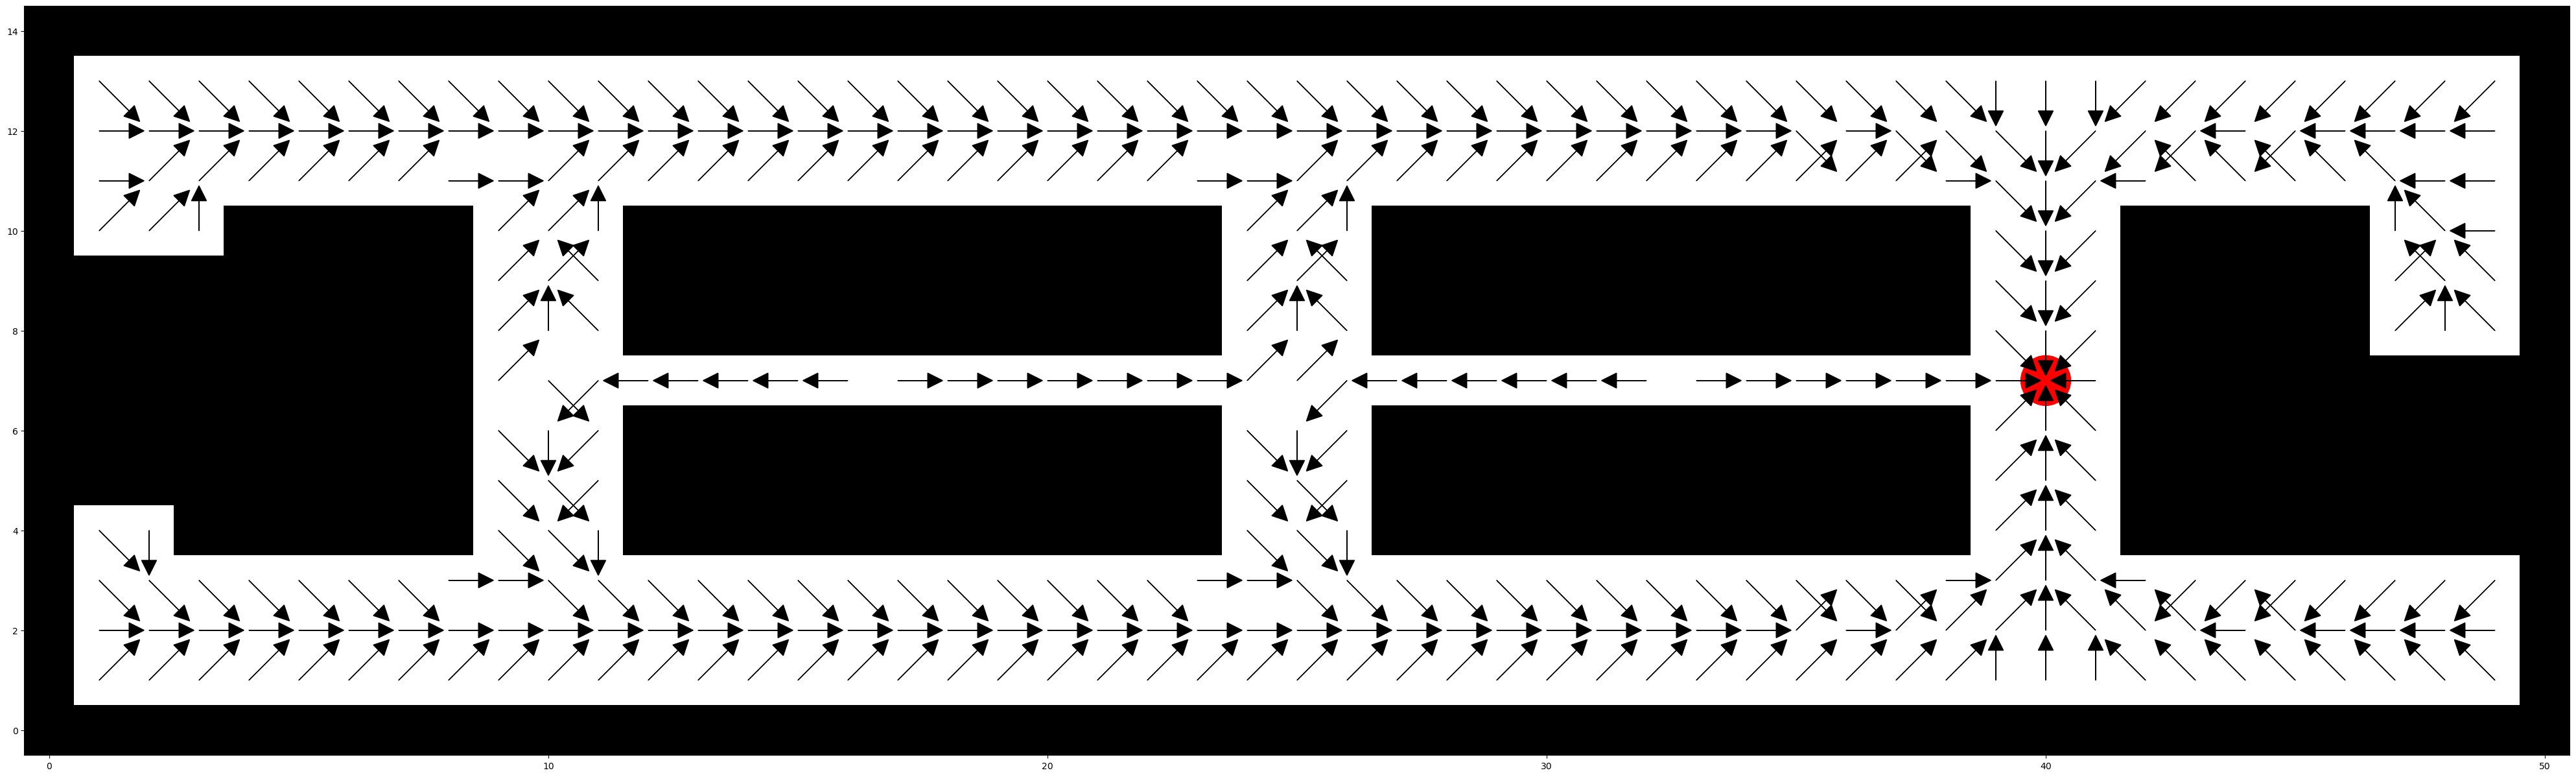

In [5]:
navigate_with_uncertainty("map.txt",-1000,-100,0.9)

  Iteration		Number of different actions
    1		  20
    2		  12
    3		  5
    4		  1
    5		  0
Iterating stopped, unchanging policy found.


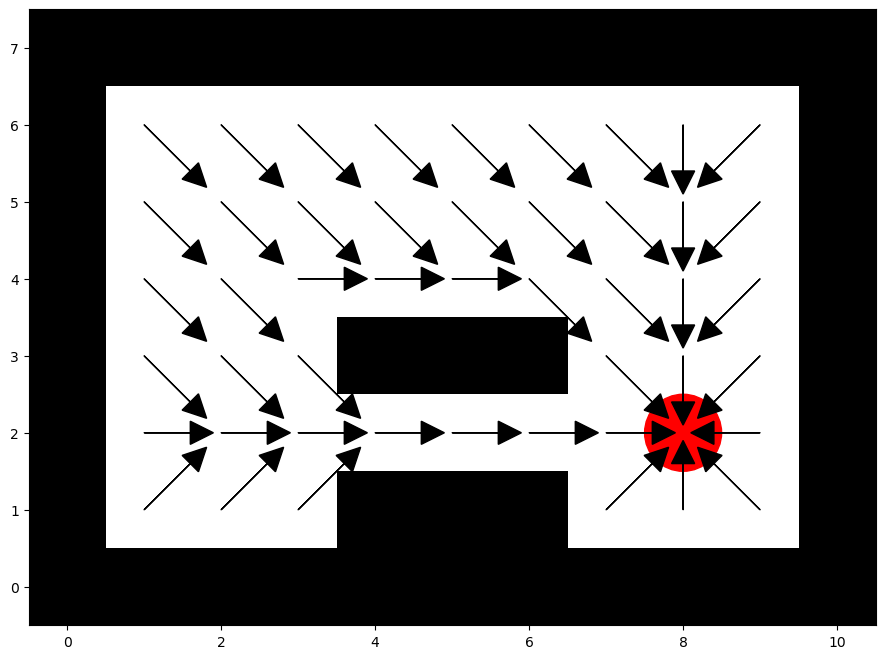

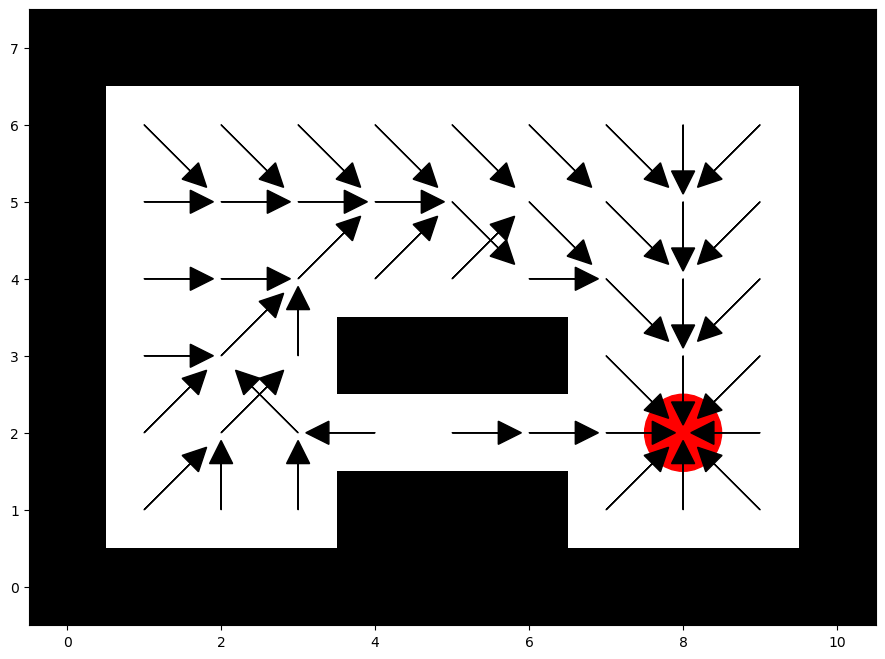

In [6]:
navigate_with_uncertainty("map1.txt",-1000,-100,0.9) # Mapa alternativo, algo más sencillo

### Ejercicio 2:

Varia los parámetros y comenta los resultados, ¿como afecta cada uno de los parámetros al resultado? 

  Iteration		Number of different actions
    1		  60
    2		  12
    3		  5
    4		  2
    5		  0
Iterating stopped, unchanging policy found.


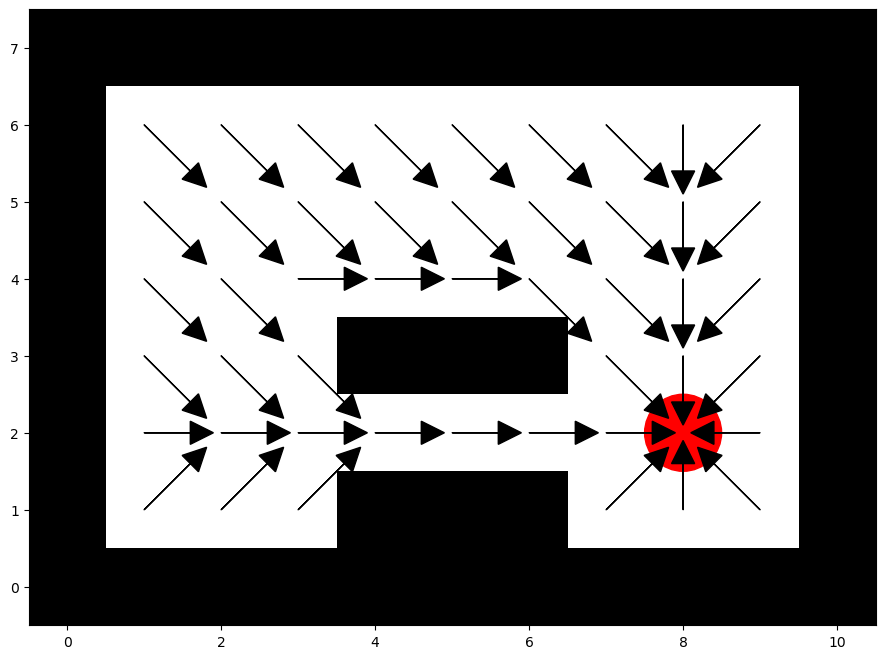

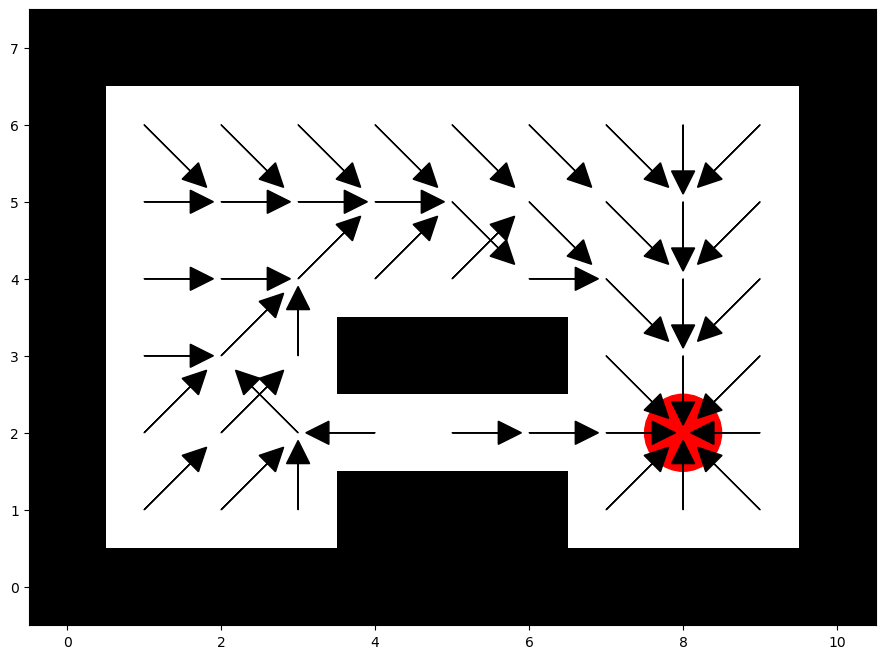

In [7]:
navigate_with_uncertainty("map1.txt",-65,-10000,0.85) 

La penalización por colisión juega un papel crucial en la navegación del robot, incitándolo a tomar caminos más seguros y evitar impactos con obstáculos. Un valor elevado en este parámetro fomenta que el robot mantenga una distancia prudencial de las paredes para minimizar riesgos de colisión. En contraste, la penalización por inactividad impulsa al robot a mantener un movimiento constante, reduciendo las pausas para deliberar y maximizando así la eficiencia al disminuir el tiempo total de inactividad. Además, el factor de descuento desempeña un papel vital; un valor demasiado bajo puede llevar a que la política resultante no aborde efectivamente el problema, ya que el robot podría menospreciar el valor de las recompensas futuras en comparación con las inmediata

### Ejercicio 3:

Plantea un mapa propio en un fichero *map2.txt* y prueba tu función

  Iteration		Number of different actions
    1		  22
    2		  9
    3		  0
Iterating stopped, unchanging policy found.


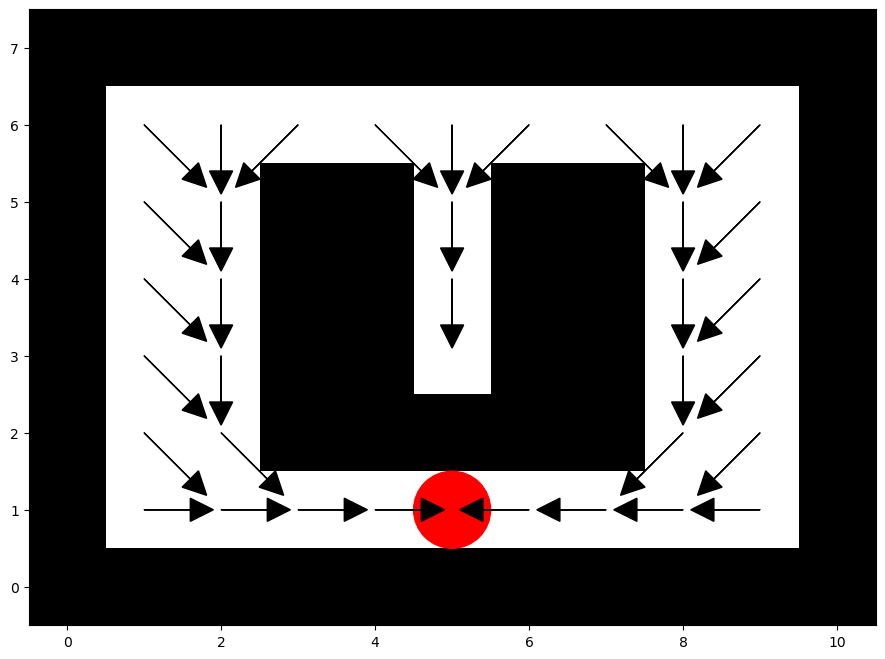

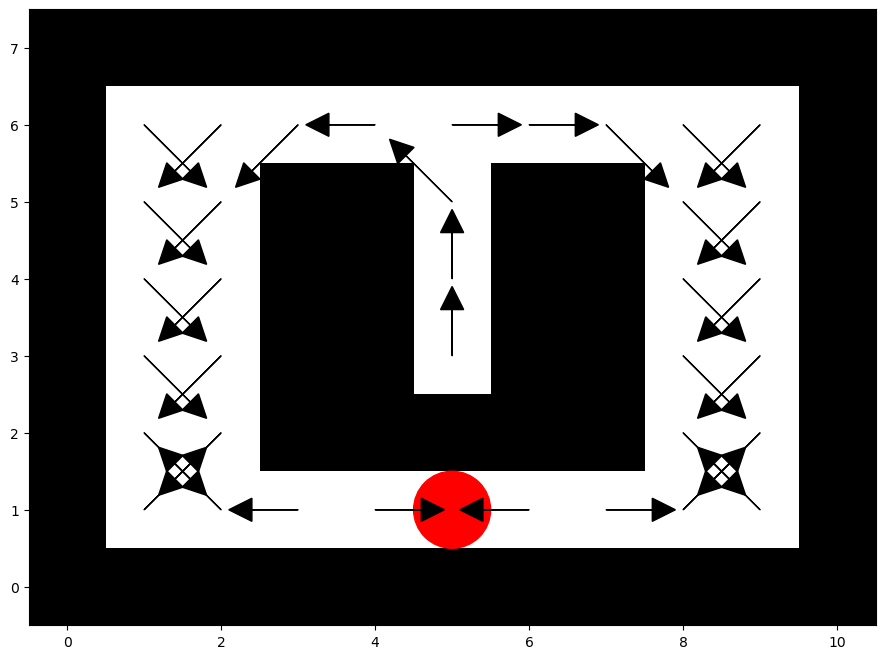

In [7]:
navigate_with_uncertainty("map3.txt",-1000,-100,0.9)

### Ejercicio 4:

Plantea algún otro problema sencillo que se pueda resolver por MDP, no necesariamente en el dominio de la robótica. Escribe el código necesario para su resolución, incluye celdas de markdown explicando el problema y su resolución. Se valorará la claridad de las explicaciones, del código y la forma de mostrar los resultados.

Imaginemos que estás planeando qué actividad realizar durante el fin de semana, y solo tienes tres opciones: ir al cine, hacer ejercicio en el gimnasio o quedarte en casa. El estado en el que te encuentras se define por cómo te sientes: feliz, aburrido o cansado.

Estados:

- Estado feliz
- Estado aburrido
- Estado cansado

Supongamos que cada día puede influir en cómo te sientes el día siguiente. Por ejemplo, si el día anterior fuiste al cine, es probable que te sientas feliz al día siguiente. Si hiciste ejercicio en el gimnasio, también es probable que te sientas feliz, pero si te quedaste en casa, podrías sentirte aburrido o cansado dependiendo de tus actividades en casa.

In [15]:
states = ['Feliz', 'Aburrido', 'Cansado']
actions = ['Cine', 'Gimnasio']

transition_matrix = np.array([
    [  # Slow action
        [0.5, 0.5, 0],  # From ok
        [0.5, 0.5, 0],  # From Warm
        [0, 0.5, 0.5]     # From Overheated 
    ],
    [  # Fast action
        [0, 1.0, 0],  # From ok
        [0, 0, 1.0],    # From Warm
        [0, 0, 1.0]     # From Overheated (stays in Overheated)
    ]
])

# Define the rewards matrix
rewards = np.array([
    [5,10],  # Recompensa del estado Feliz por las acciones Cine, Gimnasio 
    [10,5],  # Recompensa del estado Aburrido por las acciones Cine, Gimnasio 
    [5,-10 ]   #Recompensa del estado Cansado por las acciones Cine, Gimnasio
])


# Set up the discount factor
discount_factor = 0.9

# Initialize the Policy Iteration model
pi_model = mdp.PolicyIteration(transition_matrix, rewards, discount_factor)

# Run the Policy Iteration model
pi_model.run()

# The optimal policy and state values can be retrieved as follows
optimal_policy = pi_model.policy
state_values = pi_model.V

# Print the results
print("Optimal policy:", optimal_policy)
print("State values:", state_values)

Optimal policy: (1, 0, 0)
State values: (99.99999999999999, 99.99999999999999, 90.90909090909089)
